<h1> Lapakis Gerasimos - P3170089 - ICAD ASSIGNMENT 1: 2016 United States Elections</h1>

**Note: All read_csv commands use url, but the one with individual donors, itcont.txt. This file must be included in the same directory as this ipynb.**

In [1]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import matplotlib

import datetime

from collections import defaultdict

%matplotlib inline

matplotlib.style.use('ggplot')

pd.set_option('display.max_columns', None)

<h2>1. Identify the top 5 Political Action Committees (PACs), or rather, super-PACs, that supported each of the two presidential candidates, giving the amount of money raised and spent by each one of them.</h2>

In [2]:
#Contributions from committees to candidates file description
pas216header = pd.read_csv('https://www.fec.gov/files/bulk-downloads/data_dictionaries/pas2_header_file.csv')
pas216header = pas216header.columns.tolist()

data_types = { p: np.str for p in pas216header }
data_types['TRANSACTION_AMT'] = np.float

pas216 = pd.read_csv('https://www.fec.gov/files/bulk-downloads/2016/pas216.zip', 
                    sep='|', 
                    index_col=False, 
                    names=pas216header,
                    dtype=data_types)

In [3]:
contribComToCand=pas216.copy()

In [4]:
#Committee master
cm16header =  pd.read_csv('https://www.fec.gov/data/browse-data/files/bulk-downloads/data_dictionaries/cm_header_file.csv')
cm16header = cm16header.columns.tolist()

cm = pd.read_csv('https://www.fec.gov/files/bulk-downloads/2016/cm16.zip', 
                  sep='|', 
                  index_col=False, 
                  names=cm16header)

In [5]:
comMaster=cm.copy()

**We merge these two files, on committee ID, to get the committee name and committee type in the same dataframe with the other details.**

In [6]:
contribComToCand = pd.merge(contribComToCand, 
               comMaster[['CMTE_ID', 'CMTE_NM','CMTE_TP']], 
               on='CMTE_ID', 
               how='inner')

We filter out all candidate ids except ***Trump's (P80001571)*** and ***Clinton's (P00003392)***.

Here are the [FEC Committee Types](https://www.fec.gov/campaign-finance-data/committee-type-code-descriptions/) that I chose to include  
N: PAC - nonqualified  
O: Independent expenditure-only (Super PACs)  
Q: PAC - qualified  
V: PAC with non-contribution account - nonqualified  
W: PAC with non-contribution account - qaualified

In [7]:
contribComToCand = contribComToCand.loc[contribComToCand['CAND_ID'].isin(['P80001571', 'P00003392'])]
contribComToCand = contribComToCand.loc[contribComToCand['CMTE_TP'].isin(['N','O','Q','V','W'])]

Here are the [FEC Transaction Types](https://www.fec.gov/campaign-finance-data/transaction-type-code-descriptions/) that I chose to include:  
24E Independent expenditure advocating election of candidate.  
24A Independent expenditure opposing election of candidate.  
So the PACs that **supproted Trump** have Trump's ID and 24E or Clinton's ID and 24A.  
Vice versa, the PACs that **supproted Clinton** have Clinton's ID and 24E or Trump's ID and 24A.   
I also added the candidate ID after grouping by Committee ID and Name.      

**We investigate which PACs spent for both of our candidates and mark the PAC as Trump's or Clinton's based on who it spent more money on.**
This dataframe, **spentForBoth** will be used later on to link Committee IDs with Candidates.

In [8]:
spentForTrump = contribComToCand.loc[((contribComToCand['CAND_ID']=='P80001571') & (contribComToCand['TRANSACTION_TP'].isin(['24E']))) | ((contribComToCand['CAND_ID']=='P00003392') & (contribComToCand['TRANSACTION_TP']=='24A'))]
spentForTrump = spentForTrump.groupby(['CMTE_ID','CMTE_NM'],as_index=False).sum().sort_values(by='TRANSACTION_AMT', ascending=False)
spentForTrump = spentForTrump.assign(CAND_ID = 'P80001571')

In [9]:
spentForClinton = contribComToCand.loc[((contribComToCand['CAND_ID']=='P00003392') & (contribComToCand['TRANSACTION_TP'].isin(['24E']))) | ((contribComToCand['CAND_ID']=='P80001571') & (contribComToCand['TRANSACTION_TP']=='24A'))]
spentForClinton = spentForClinton.groupby(['CMTE_ID','CMTE_NM'],as_index=False).sum().sort_values(by='TRANSACTION_AMT', ascending=False)
spentForClinton = spentForClinton.assign(CAND_ID = 'P00003392')

In [10]:
spentForBoth = pd.concat([spentForTrump, spentForClinton],ignore_index=True)
spentForBoth = spentForBoth.groupby(['CMTE_ID','CAND_ID'],as_index=False)
spentForBoth = spentForBoth.sum().sort_values(by='TRANSACTION_AMT', ascending=True).drop_duplicates(['CMTE_ID','CMTE_ID'],keep='last')

We now merge our dataframes, after we have eliminated PACs that appear 2 times.

In [11]:
spentForClinton = pd.merge(spentForClinton [['CMTE_ID', 'CMTE_NM','TRANSACTION_AMT']] ,
               spentForBoth[['CMTE_ID', 'CAND_ID']], 
               on='CMTE_ID', 
               how='inner')

spentForClinton = spentForClinton[spentForClinton['CAND_ID'].isin(['P00003392'])]
spentForClinton.head(5)

,CMTE_ID,CMTE_NM,TRANSACTION_AMT,CAND_ID
0,C00495861,PRIORITIES USA ACTION,132535920.0,P00003392
1,C00603621,OUR PRINCIPLES PAC,16353117.0,P00003392
2,C00523621,UNITED WE CAN,13499952.0,P00003392
3,C00615815,NEXTGEN CALIFORNIA ACTION COMMITTEE,13240861.0,P00003392
4,C00473918,WOMEN VOTE!,11627748.0,P00003392


In [12]:
spentForTrump = pd.merge(spentForTrump [['CMTE_ID', 'CMTE_NM','TRANSACTION_AMT']] ,
               spentForBoth[['CMTE_ID', 'CAND_ID']], 
               on='CMTE_ID', 
               how='inner')

spentForTrump = spentForTrump[spentForTrump['CAND_ID'].isin(['P80001571'])]
spentForTrump.head(5)

,CMTE_ID,CMTE_NM,TRANSACTION_AMT,CAND_ID
0,C00574533,FUTURE45,24219101.0,P80001571
1,C00608489,GREAT AMERICA PAC,23885544.0,P80001571
2,C00618876,REBUILDING AMERICA NOW,21197098.0,P80001571
3,C00053553,NATIONAL RIFLE ASSOCIATION OF AMERICA POLITICA...,9315549.0,P80001571
4,C00490730,RGA RIGHT DIRECTION PAC,5728857.0,P80001571


We do the same thing for money raised, merging the PAC summary file with the dataframes that we created above, as they contain the committee ids that supported each candidate.

The header for the PAC doesn't exist on the FEC site so, I wrote it by hand.

In [13]:
pachead = ['CMTE_ID','CMTE_NM','CMTE_TP','CMTE_DSGN','CMTE_FILING_FREQ','TTL_RECEIPTS','TRANS_FROM_AFF','INDV_CONTRIB','OTHER_POL_CMTE_CONTRIB','CAND_CONTRIB','CAND_LOANS','TTL_LOANS_RECEIVED','TTL_DISB','TRANF_TO_AFF',
        'INDV_REFUNDS','OTHER_POL_CMTE_REFUNDS','CAND_LOAN_REPAY','LOAN_REPAY','COH_BOP','COH_COP','DEBTS_OWED_BY','NONFED_TRANS_RECEIVED','CONTRIB_TO_OTHER_CMTE','IND_EXP','PTY_COORD_EXP','NONFED_SHARE_EXP','CVG_END_DT']

data_types = { h: np.str for h in pachead }
data_types['TTL_RECEIPTS'] = np.float

pac = pd.read_csv('https://www.fec.gov/files/bulk-downloads/2016/webk16.zip', 
                  sep='|', 
                  index_col=False, 
                  names=pachead, 
                  dtype=data_types)

In [14]:
pacSum=pac.copy()

We use the same committee types as above.

In [15]:
pacSum = pacSum.loc[pacSum['CMTE_TP'].isin(['N', 'O','Q','V','W'])]

In [16]:
raisedForTrump = pd.merge(pacSum, 
               spentForTrump[['CMTE_ID', 'CAND_ID']], 
               on='CMTE_ID', 
               how='inner')

In [17]:
raisedForClinton = pd.merge(pacSum, 
               spentForClinton[['CMTE_ID', 'CAND_ID']], 
               on='CMTE_ID', 
               how='inner')

TTL_RECEIPTS are the money that were given to the PAC.

In [18]:
raisedForTrump = raisedForTrump.sort_values(by='TTL_RECEIPTS',ascending=False)
raisedForTrump.round().head(5)

,CMTE_ID,CMTE_NM,CMTE_TP,CMTE_DSGN,CMTE_FILING_FREQ,TTL_RECEIPTS,TRANS_FROM_AFF,INDV_CONTRIB,OTHER_POL_CMTE_CONTRIB,CAND_CONTRIB,CAND_LOANS,TTL_LOANS_RECEIVED,TTL_DISB,TRANF_TO_AFF,INDV_REFUNDS,OTHER_POL_CMTE_REFUNDS,CAND_LOAN_REPAY,LOAN_REPAY,COH_BOP,COH_COP,DEBTS_OWED_BY,NONFED_TRANS_RECEIVED,CONTRIB_TO_OTHER_CMTE,IND_EXP,PTY_COORD_EXP,NONFED_SHARE_EXP,CVG_END_DT,CAND_ID
58,C00608489,GREAT AMERICA PAC,W,U,Q,28684573.0,0,13312968.49,0,0,0,0,26625503.11,0,40239.52,50,0,50000,0,2059069.57,0,0,86994,23608329.91,0,0,12/31/2016,P80001571
34,C00564765,"FREEDOM PARTNERS ACTION FUND, INC.",O,U,M,28201407.0,0,26563016.84,0,0,0,0,31461728.48,0,0,0,0,0,3355538.53,95217.1,3000,0,100000,29728850.26,0,0,12/31/2016,P80001571
44,C00574533,FUTURE45,O,U,Q,24996520.0,0,24955520.04,41000,0,0,0,24970329.55,0,0,0,0,0,0,26190.49,0,0,150000,24264041.87,0,0,12/31/2016,P80001571
66,C00618876,REBUILDING AMERICA NOW,O,U,Q,23616517.0,0,23472474.94,50000,0,0,0,22774745.33,0,2000,0,0,0,0,841771.61,0,0,0,19817596.85,0,0,12/31/2016,P80001571
16,C00490730,RGA RIGHT DIRECTION PAC,O,U,Q,22781721.0,0,0,20725000,0,0,0,22348069.83,0,0,0,0,0,3101.53,436752.44,0,0,0,5426475.67,0,0,12/31/2016,P80001571


In [19]:
raisedForClinton = raisedForClinton.sort_values(by='TTL_RECEIPTS',ascending=False)
raisedForClinton.round().head(5)

,CMTE_ID,CMTE_NM,CMTE_TP,CMTE_DSGN,CMTE_FILING_FREQ,TTL_RECEIPTS,TRANS_FROM_AFF,INDV_CONTRIB,OTHER_POL_CMTE_CONTRIB,CAND_CONTRIB,CAND_LOANS,TTL_LOANS_RECEIVED,TTL_DISB,TRANF_TO_AFF,INDV_REFUNDS,OTHER_POL_CMTE_REFUNDS,CAND_LOAN_REPAY,LOAN_REPAY,COH_BOP,COH_COP,DEBTS_OWED_BY,NONFED_TRANS_RECEIVED,CONTRIB_TO_OTHER_CMTE,IND_EXP,PTY_COORD_EXP,NONFED_SHARE_EXP,CVG_END_DT,CAND_ID
132,C00495861,PRIORITIES USA ACTION,O,B,M,192065768.0,49900,156716319.72,30083034.37,0,0,0,190710175.02,76075,204925,0,0,0,457781.34,1813373.9,0,0,30101586.38,133408056.41,0,0,12/31/2016,P00003392
60,C00571372,RIGHT TO RISE USA,O,B,M,121695224.0,0,118359926.62,363500,0,0,0,118328360.63,0,13891824.57,36270.35,0,0,0,3366863.42,0,0,0,86817478.31,0,0,12/31/2016,P00003392
50,C00547349,NEXTGEN CLIMATE ACTION COMMITTEE,O,U,M,93010237.0,21129.79,91101627.43,500000,0,0,0,96036920.62,13160000,157.25,0,0,0,3804784.75,778101,0,0,28392484.45,9784794.95,0,0,12/31/2016,P00003392
31,C00484642,SENATE MAJORITY PAC,O,U,M,92821081.0,0,67715745.98,23662570,0,0,0,91204417.22,76075,199308.63,0,0,0,179373.32,1796036.77,48633.2,0,5601094,75413534.87,0,0,12/31/2016,P00003392
48,C00541292,CONSERVATIVE SOLUTIONS PAC,O,U,M,60564219.0,0,60234219.16,330000,0,0,0,60368634.96,0,30000,0,0,0,86,195670.2,0,0,1840000,55443629.89,0,0,12/31/2016,P00003392


<h2>2. Identify the top 10 individual donors (i.e., persons) for each of the two presidential candidates and the amount they spent. In order to do that, you should know that donations are not always to a fundraising committee that can be directly linked to a candidate, but they can be due to other entities such as PACs.</h2>

In [20]:
indivheader = pd.read_csv('https://www.fec.gov/files/bulk-downloads/data_dictionaries/indiv_header_file.csv', parse_dates=['TRANSACTION_DT'])
indivheader = indivheader.columns.tolist()

data_types = { h: np.str for h in indivheader }
data_types['TRANSACTION_AMT'] = np.float

fectemp = pd.read_csv('itcont.txt',
                        parse_dates=['TRANSACTION_DT'], 
                        sep='|', 
                        index_col=False, 
                        names=indivheader,
                        dtype=data_types)

In [21]:
fec=fectemp.copy()

We only keep Individuals (IND), as we want individual donors.  
Also, when we display the top 10 individuals for Clinton, we will see ***ASSOCIATION, NATIONAL EDUCATION*** because it is declared as IND, instead of PAC so we change it.  

In [22]:
fec.loc[fec['NAME'] == 'ASSOCIATION, NATIONAL EDUCATION', ['ENTITY_TP']] = 'PAC'
fec=fec.loc[fec['ENTITY_TP'].isin(['IND'])]

Some individuals in top 10 have their names written in numerous ways, so we want to correct them, to get the actual amounts per individual.  

In [23]:
name_filtering = {
        'SUSSMAN, S. DONALD' : 'SUSSMAN, DONALD',
        'SUSSMAN, S DONALD' : 'SUSSMAN, DONALD',
        'SUSSMAN, DONALD S' : 'SUSSMAN, DONALD',
        'SUSSMAN, SELWYN DONALD' : 'SUSSMAN, DONALD',
        'SUSSMAN, DONALD S.' : 'SUSSMAN, DONALD',

        'SIMONS, JAMES H' : 'SIMONS, JAMES' ,
        'SIMONS, JAMES H.' : 'SIMONS, JAMES' ,
    
        'HENDRICKS, DIANE MS.' : 'HENDRICKS, DIANE'
}

f = lambda x: name_filtering.get(x, x) 
fec.loc[:, 'NAME'] = fec.loc[:, 'NAME'].map(f)

We use spentForBoth to separate the candidate ids and merge them, on committee id, with the individuals.

In [24]:
indivForTrump = pd.merge(fec, 
               spentForBoth[['CMTE_ID','CAND_ID']], 
               on='CMTE_ID', 
               how='inner')
indivForTrump = indivForTrump.loc[indivForTrump['CAND_ID']=='P80001571']

In [25]:
indivForClinton = pd.merge(fec, 
               spentForBoth[['CMTE_ID','CAND_ID']], 
               on='CMTE_ID', 
               how='inner')
indivForClinton = indivForClinton.loc[indivForClinton['CAND_ID']=='P00003392']

And now, group by individual name.

In [26]:
indivForTrump = indivForTrump.groupby(['NAME'],as_index=False).sum().sort_values(by='TRANSACTION_AMT', ascending=False)
indivForTrump.head(10)

,NAME,TRANSACTION_AMT
29785,"MERCER, ROBERT",15500000.0
19168,"HENDRICKS, DIANE",12152900.0
184,"ADELSON, SHELDON",10000000.0
183,"ADELSON, MIRIAM",10000000.0
29356,"MCMAHON, LINDA E.",7000000.0
27685,"MARCUS, BERNARD",7000000.0
45290,"UIHLEIN, RICHARD E.",5240000.0
34312,"PERLMUTTER, ISAAC",5000000.0
33554,"PALMER, GEOFFREY H.",4000000.0
2441,"BEAL, DANIEL A.",3615764.0


In [27]:
indivForClinton = indivForClinton.groupby(['NAME'],as_index=False).sum().sort_values(by='TRANSACTION_AMT', ascending=False)
indivForClinton.head(10)

,NAME,TRANSACTION_AMT
47730,"STEYER, THOMAS F.",89500000.0
48352,"SUSSMAN, DONALD",37050000.0
14510,"EYCHANER, FRED",35350000.0
45783,"SIMONS, JAMES",22000680.0
4432,"BLOOMBERG, MICHAEL R.",21665124.0
46792,"SOROS, GEORGE",20099693.0
34929,"MOSKOVITZ, DUSTIN",16528000.0
39772,"PRITZKER, JAY ROBERT",9650848.0
79,"ABRAHAM, DANIEL",9250000.0
39775,"PRITZKER, MARY KATHRYN",7550000.0


<h2>3. Investigate the chronological evolution of the contributions made to and the expenditures made by the campaigns.</h2>

In [28]:
opexphead =  pd.read_csv('https://www.fec.gov/data/browse-data/files/bulk-downloads/data_dictionaries/oppexp_header_file.csv', parse_dates=['TRANSACTION_DT'])
opexphead = opexphead.columns.tolist()

data_types = { h: np.str for h in opexphead }
data_types['TRANSACTION_AMT'] = np.float

opex = pd.read_csv('https://www.fec.gov/files/bulk-downloads/2016/oppexp16.zip', 
                    parse_dates=['TRANSACTION_DT'],
                    sep='|', 
                    index_col=False, 
                    names=opexphead,
                    dtype=data_types)

In [29]:
opexC = opex.copy()

We only keep transaction dates from 2015-2016.

In [30]:
opexC['TRANSACTION_DT'] = pd.to_datetime(opexC['TRANSACTION_DT'], errors='coerce').dt.date
opexC = opexC[(opexC['TRANSACTION_DT'] >= datetime.date(year=2015,month=1,day=1))& (opexC['TRANSACTION_DT'] < datetime.date(year=2017,month=1,day=1))]
opexC['TRANSACTION_AMT'] = opexC['TRANSACTION_AMT'].round()

In [31]:
expBoth = pd.merge(opexC, 
               comMaster[['CMTE_ID','CAND_ID','CMTE_TP']], 
               on='CMTE_ID', 
               how='inner')

In [32]:
expBothTemp = pd.merge(opexC, 
               spentForBoth[['CMTE_ID','CAND_ID']], 
               on='CMTE_ID', 
               how='inner')

We get operating expenses with committee type P(Presidential, Campaign committee for candidate for U.S. President) and filter them by candidate ID.  
We also concat PACs' expenses by candidate.  
We set transaction date as an index and group by month, adding all transactions for a month.

In [33]:
expTrump = expBoth.loc[expBoth['CAND_ID']=='P80001571']
expTrump = expTrump.loc[expTrump['CMTE_TP']=='P']

expTrumpTemp = expBothTemp.loc[((expBothTemp['CAND_ID']=='P80001571'))]
expTrump = pd.concat([expTrump, expTrumpTemp],ignore_index=True)

expTrump = expTrump.set_index(pd.DatetimeIndex(expTrump['TRANSACTION_DT']))
expTrump = expTrump.groupby(pd.Grouper(freq='M')).sum().sort_values(by='TRANSACTION_AMT', ascending=False).reset_index()
expTrump = expTrump.sort_values(by='TRANSACTION_DT')
expTrump

,TRANSACTION_DT,TRANSACTION_AMT
23,2015-01-31,1307860.0
22,2015-02-28,1612992.0
21,2015-03-31,2025378.0
19,2015-04-30,2323318.0
20,2015-05-31,2252388.0
18,2015-06-30,2890667.0
17,2015-07-31,3273155.0
15,2015-08-31,3818321.0
14,2015-09-30,3948265.0
16,2015-10-31,3729150.0


(array([735599., 735689., 735780., 735872., 735964., 736055., 736146.,
        736238., 736330.]),
 <a list of 9 Text major ticklabel objects>)

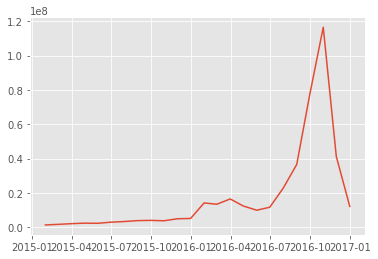

In [34]:
plt.plot(expTrump['TRANSACTION_DT'], expTrump['TRANSACTION_AMT'])
plt.xticks(rotation='horizontal')

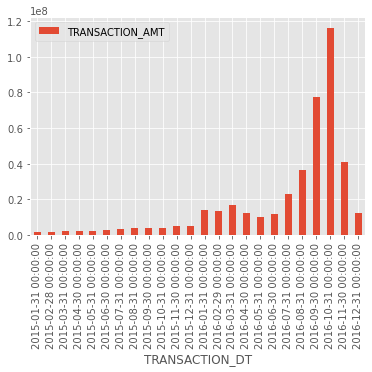

In [35]:
expTrump.plot(x ='TRANSACTION_DT', y='TRANSACTION_AMT', kind = 'bar')

In [36]:
expClinton = expBoth.loc[expBoth['CAND_ID']=='P00003392']
expClinton = expClinton.loc[expClinton['CMTE_TP']=='P']

expClintonTemp = expBothTemp.loc[((expBothTemp['CAND_ID']=='P00003392'))]
expClinton = pd.concat([expClinton, expClintonTemp],ignore_index=True)
                                 
                                 
expClinton = expClinton.set_index(pd.DatetimeIndex(expClinton['TRANSACTION_DT']))
expClinton = expClinton.groupby(pd.Grouper(freq='M')).sum().sort_values(by='TRANSACTION_AMT', ascending=False).reset_index()
expClinton = expClinton.sort_values(by='TRANSACTION_DT')
expClinton ['TRANSACTION_DT'] = expClinton ['TRANSACTION_DT']

(array([735599., 735689., 735780., 735872., 735964., 736055., 736146.,
        736238., 736330.]),
 <a list of 9 Text major ticklabel objects>)

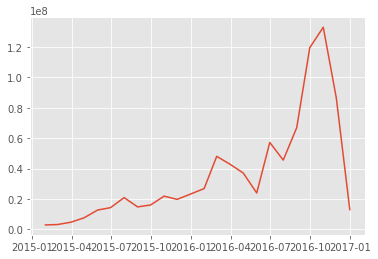

In [37]:
plt.plot(expClinton['TRANSACTION_DT'], expClinton['TRANSACTION_AMT'])
plt.xticks(rotation='horizontal')

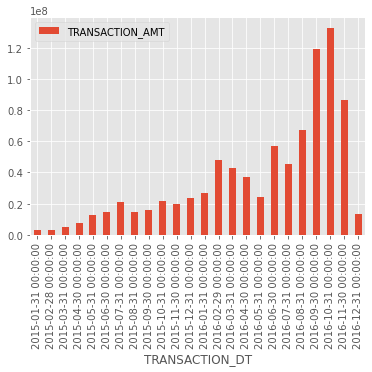

In [38]:
expClinton.plot(x ='TRANSACTION_DT', y='TRANSACTION_AMT', kind = 'bar')

In [39]:
contribs=fectemp.copy()

We do the same thing for contributions!

In [40]:
contribs['TRANSACTION_DT'] = pd.to_datetime(contribs['TRANSACTION_DT'], format='%d%m%Y', errors='coerce')
contribs = contribs[(contribs['TRANSACTION_DT'].dt.date >= datetime.date(year=2015,month=1,day=1))& (contribs['TRANSACTION_DT'].dt.date < datetime.date(year=2017,month=1,day=1))]

In [41]:
conBoth = pd.merge(contribs, 
                    comMaster[['CMTE_ID','CAND_ID','CMTE_TP']], 
                    on='CMTE_ID', 
                    how='inner')

In [42]:
conBothTemp = pd.merge(contribs, 
                    spentForBoth[['CMTE_ID','CAND_ID']], 
                    on='CMTE_ID', 
                    how='inner')

In [43]:
conClinton = conBoth.loc[conBoth['CAND_ID']=='P00003392']
conClinton = conClinton.loc[conClinton['CMTE_TP']=='P']

conClintonTemp = conBothTemp.loc[((conBothTemp['CAND_ID']=='P00003392'))]
conClinton = pd.concat([conClinton, conClintonTemp],ignore_index=True)

conClinton = conClinton.set_index(pd.DatetimeIndex(conClinton['TRANSACTION_DT']))
conClinton = conClinton.groupby(pd.Grouper(freq='M')).sum().sort_values(by='TRANSACTION_AMT', ascending=False).reset_index()
conClinton = conClinton.sort_values(by='TRANSACTION_DT')
conClinton

,TRANSACTION_DT,TRANSACTION_AMT
22,2015-01-31,5001947.0
19,2015-02-28,5675434.0
12,2015-03-31,11347586.0
16,2015-04-30,7136248.0
23,2015-05-31,4026784.0
21,2015-06-30,5113076.0
14,2015-07-31,7910246.0
13,2015-08-31,10137879.0
17,2015-09-30,6688996.0
15,2015-10-31,7617871.0


(array([735599., 735689., 735780., 735872., 735964., 736055., 736146.,
        736238., 736330.]),
 <a list of 9 Text major ticklabel objects>)

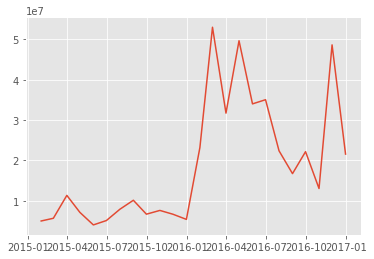

In [44]:
plt.plot(conClinton['TRANSACTION_DT'], conClinton['TRANSACTION_AMT'])
plt.xticks(rotation='horizontal')

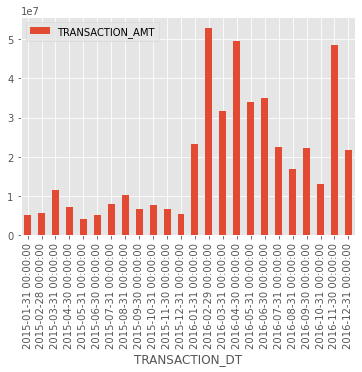

In [45]:
conClinton.plot(x ='TRANSACTION_DT', y='TRANSACTION_AMT', kind = 'bar')

In [46]:
conTrump = conBoth.loc[conBoth['CAND_ID']=='P80001571']
conTrump = conTrump.loc[conTrump['CMTE_TP']=='P']

conTrumpTemp = conBothTemp.loc[((conBothTemp['CAND_ID']=='P80001571'))]
conTrump = pd.concat([conTrump, conTrumpTemp],ignore_index=True)

conTrump = conTrump.set_index(pd.DatetimeIndex(conTrump['TRANSACTION_DT']))
conTrump = conTrump.groupby(pd.Grouper(freq='M')).sum().sort_values(by='TRANSACTION_AMT', ascending=False).reset_index()
conTrump = conTrump.sort_values(by='TRANSACTION_DT')
conTrump

,TRANSACTION_DT,TRANSACTION_AMT
17,2015-01-31,839281.0
15,2015-02-28,1082914.0
19,2015-03-31,550071.0
22,2015-04-30,389579.0
20,2015-05-31,495362.0
13,2015-06-30,2314768.0
11,2015-07-31,2355416.0
21,2015-08-31,461146.0
16,2015-09-30,944202.0
1,2015-10-31,11974823.0


(array([735599., 735689., 735780., 735872., 735964., 736055., 736146.,
        736238., 736330.]),
 <a list of 9 Text major ticklabel objects>)

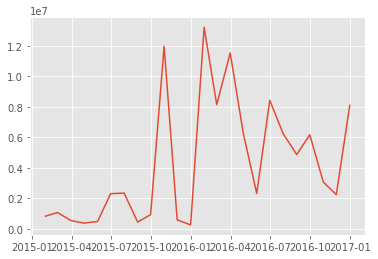

In [47]:
plt.plot(conTrump['TRANSACTION_DT'], conTrump['TRANSACTION_AMT'])
plt.xticks(rotation='horizontal')

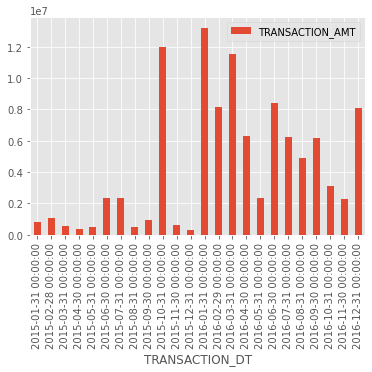

In [48]:
conTrump.plot(x ='TRANSACTION_DT', y='TRANSACTION_AMT', kind = 'bar')

<h2>4. Identify the biggest recipients of campaign expenditures.</h2>

In [49]:
recipientsAll=opex.copy()

In [50]:
recipientsAllTemp = pd.merge(recipientsAll, 
                    spentForBoth[['CMTE_ID','CAND_ID']], 
                    on='CMTE_ID', 
                    how='inner')

In [51]:
recipientsAll = pd.merge(recipientsAll, 
                    comMaster[['CMTE_ID','CAND_ID','CMTE_TP']], 
                    on='CMTE_ID', 
                    how='inner')

In [52]:
recipientsTTL = recipientsAll.loc[recipientsAll['CMTE_TP']=='P']
recipientsTTL = recipientsTTL.loc[recipientsTTL['CAND_ID'].isin(['P80001571','P00003392'])]
recipientsTTL = pd.concat([recipientsTTL, recipientsAllTemp],ignore_index=True)
recipientsTTL = recipientsTTL.groupby(['NAME']).sum().sort_values(by='TRANSACTION_AMT', ascending=False).reset_index().head(10)
recipientsTTL.round()

,NAME,TRANSACTION_AMT
0,GMMB,308463389.0
1,GILES-PARSCALE,87838378.0
2,AMERICAN MEDIA & ADVOCACY GROUP,74176379.0
3,AMERICAN EXPRESS,46686851.0
4,BULLY PULPIT INTERACTIVE LLC,40135084.0
5,ADP,30603796.0
6,"RICK REED MEDIA, INC.",24460099.0
7,MARKHAM PRODUCTIONS,16025852.0
8,"ACE SPECIALTIES, LLC",15885324.0
9,EXECUTIVE FLITEWAYS,15866289.0


As in question 3, we keep the PACs and the committee types P, filtering by candidate.  
Finally we group by NAME.  

In [53]:
recipientsTr = recipientsAll.loc[recipientsAll['CMTE_TP']=='P']
recipientsTr = recipientsTr.loc[recipientsTr['CAND_ID']=='P80001571']
recipientsTrTemp = recipientsAllTemp.loc[((recipientsAllTemp['CAND_ID']=='P80001571'))]
recipientsTr = pd.concat([recipientsTr, recipientsTrTemp],ignore_index=True)

In [54]:
recipientsCl = recipientsAll.loc[recipientsAll['CMTE_TP']=='P']
recipientsCl = recipientsCl.loc[recipientsCl['CAND_ID']=='P00003392']
recipientsClTemp = recipientsAllTemp.loc[((recipientsAllTemp['CAND_ID']=='P00003392'))]
recipientsCl = pd.concat([recipientsCl, recipientsClTemp],ignore_index=True)

In [55]:
recipientsCl = recipientsCl.groupby(['NAME']).sum().sort_values(by='TRANSACTION_AMT', ascending=False).reset_index().head(10)
recipientsCl.round()

,NAME,TRANSACTION_AMT
0,GMMB,308463389.0
1,BULLY PULPIT INTERACTIVE LLC,40135084.0
2,ADP,29100104.0
3,AMERICAN EXPRESS,27259410.0
4,MARKHAM PRODUCTIONS,16025852.0
5,EXECUTIVE FLITEWAYS,15866289.0
6,PAYROLL DATA PROCESSING,11248382.0
7,"AIR PARTNERS, INC.",11156326.0
8,STRIPE,10334578.0
9,SEIU GENERAL FUND,7886324.0


In [56]:
recipientsTr = recipientsTr.groupby(['NAME']).sum().sort_values(by='TRANSACTION_AMT', ascending=False).reset_index().head(10)
recipientsTr.round()

,NAME,TRANSACTION_AMT
0,GILES-PARSCALE,87838378.0
1,AMERICAN MEDIA & ADVOCACY GROUP,74176379.0
2,"RICK REED MEDIA, INC.",24460099.0
3,AMERICAN EXPRESS,19427441.0
4,"ACE SPECIALTIES, LLC",15885324.0
5,"PRIVATE JET SERVICES, LLC",9953216.0
6,JAMESTOWN ASSOCIATES,8836595.0
7,"TAG AIR, INC.",8741464.0
8,AIR CHARTER TEAM,8321403.0
9,"CAMBRIDGE ANALYTICA, LLC",5912500.0


<h2>5. Examine the geographical distribution, at the state level, of campaign expenditures. For each state, calculate the expenditures per voter. This will require that you find a source with the number of registered voters per state. Examine the situation for swing states.</h2>

In [57]:
perStateExp = opex.copy()

Calculating how much expenses were for each candidate, doing the same thing as in questions 3 and 4.  

In [58]:
perStateExpTemp = pd.merge(perStateExp, 
               spentForBoth[['CMTE_ID','CAND_ID']], 
               on='CMTE_ID', 
               how='inner')

In [59]:
perStateExp = pd.merge(perStateExp, 
               comMaster[['CMTE_ID','CAND_ID','CMTE_TP']], 
               on='CMTE_ID', 
               how='inner')
perStateExp = perStateExp.loc[perStateExp['CMTE_TP']=='P']

In [60]:
perStateExpTempTr = perStateExpTemp.loc[perStateExpTemp['CAND_ID']=='P80001571']
perStateExpTr = perStateExp.loc[perStateExp['CAND_ID']=='P80001571']
perStateExpTr = pd.concat([perStateExpTr, perStateExpTempTr],ignore_index=True)
perStateExpTr = perStateExpTr.groupby(['STATE']).sum().sort_values(by='TRANSACTION_AMT', ascending=False).reset_index()

In [61]:
perStateExpTempCl = perStateExpTemp.loc[perStateExpTemp['CAND_ID']=='P00003392']
perStateExpCl = perStateExp.loc[perStateExp['CAND_ID']=='P00003392']
perStateExpCl = pd.concat([perStateExpCl, perStateExpTempCl],ignore_index=True)
perStateExpCl = perStateExpCl.groupby(['STATE']).sum().sort_values(by='TRANSACTION_AMT', ascending=False).reset_index()

[Registered Voters Per State 2016](https://www.eac.gov/research-and-data/datasets-codebooks-and-surveys)  
The source of data is The U.S. Election Assistance Commission (EAC).

According to [The 2016 Election Administration and Voting Survey Codebook](https://www.eac.gov/research-and-data/datasets-codebooks-and-surveys), column **A1a's description** : *Enter the total number of persons in your jurisdiction who were registered and eligible to vote in
the November 2016 general election. Include all persons eligible to vote in the election including
special categories of voters with extended deadlines (such as returning military). Do not include any
persons under the age of 18 who may be registered under a “pre-registration” program.*

Excluded Puerto Rico (PR) and District of Columbia (DC), as they are not states.  
Also removed North Dakota (ND), as [North Dakota does not require voter registration](https://vote.nd.gov/PortalListDetails.aspx?ptlhPKID=79&ptlPKID=7), so expenses per voters appear as infinite.

In [62]:
regVoters = pd.read_csv('https://www.eac.gov/sites/default/files/Research/EAVS_2016_Final_Data_for_Public_Release_v2.csv.zip', usecols=['State', 'A1a'],low_memory=False)

regVoters['A1a'] = pd.to_numeric(regVoters['A1a'], errors='coerce')
regVoters = regVoters.rename(columns={'State': 'STATE', 'A1a': 'VOTERS'})
regVoters = regVoters[~regVoters['STATE'].isin(['ND','PR','DC'])]
regVoters = regVoters.groupby(['STATE']).sum().sort_values(by='VOTERS')

In [63]:
perStateExpTr = pd.merge(perStateExpTr, 
               regVoters, 
               on='STATE', 
               how='inner')

perStateExpTr['EXP_PER_VOTER'] = perStateExpTr['TRANSACTION_AMT'] / perStateExpTr['VOTERS']
perStateExpTr.sort_values(by='EXP_PER_VOTER',ascending=False)

,STATE,TRANSACTION_AMT,VOTERS,EXP_PER_VOTER
0,VA,1.296236e+08,5604106.0,23.130117
6,NH,1.174327e+07,988398.0,11.881112
1,TX,9.796101e+07,14382387.0,6.811179
4,LA,1.721136e+07,3058741.0,5.626944
13,DE,3.393263e+06,675663.0,5.022124
17,SD,2.852902e+06,595322.0,4.792199
3,NJ,1.954661e+07,5751090.0,3.398766
8,MO,9.622494e+06,4215860.0,2.282451
2,NY,2.855518e+07,16200892.0,1.762569
46,VI,7.413969e+04,46076.0,1.609074


In [64]:
perStateExpCl = pd.merge(perStateExpCl, 
               regVoters, 
               on='STATE', 
               how='inner')

perStateExpCl['EXP_PER_VOTER'] = perStateExpCl['TRANSACTION_AMT'] / perStateExpCl['VOTERS']
perStateExpCl['TRANSACTION_AMT'] = perStateExpCl['TRANSACTION_AMT'].round()
perStateExpCl.sort_values(by='EXP_PER_VOTER',ascending=False)

,STATE,TRANSACTION_AMT,VOTERS,EXP_PER_VOTER
1,NJ,56440465.0,5751090.0,9.813873
5,AR,16828425.0,1765513.0,9.531748
0,NY,104785340.0,16200892.0,6.467875
9,CT,12108966.0,2331684.0,5.193228
18,RI,3597834.0,754065.0,4.771251
17,NH,3970354.0,988398.0,4.016959
14,IA,8005178.0,2222380.0,3.602074
7,CO,12840688.0,3840303.0,3.343665
4,VA,18732256.0,5604106.0,3.342595
13,MD,10202130.0,3900090.0,2.615870


According to [Wikipedia](https://en.wikipedia.org/wiki/Swing_state#Swing_states_by_results), 2016 USA election **swing states are Maine, Nevada, Minnesota, New Hampshire, Michigan, Pennsylvania, Wisconsin, Florida, Arizona, North Carolina and Georgia.**

In [65]:
perStateExpTrSwings = perStateExpTr.loc[perStateExpTr['STATE'].isin(['ME', 'NV','MN','NH','MI','PA','WI','FL','AZ','NC','GA'])]
perStateExpTrSwings.sort_values(by='EXP_PER_VOTER',ascending=False)

,STATE,TRANSACTION_AMT,VOTERS,EXP_PER_VOTER
6,NH,11743267.33,988398.0,11.881112
10,AZ,6336801.88,4080680.0,1.552879
5,FL,16416871.35,13505571.0,1.215563
23,NV,1406317.61,1678883.0,0.837651
11,GA,4496048.05,6657621.0,0.675324
18,NC,2488505.28,6924469.0,0.359378
28,WI,1043587.25,3768373.0,0.276933
19,PA,2364319.72,8722975.0,0.271045
34,MN,600545.17,3473972.0,0.172870
29,MI,939034.26,7514055.0,0.124970


In [66]:
perStateExpClSwings = perStateExpCl.loc[perStateExpCl['STATE'].isin(['ME', 'NV','MN','NH','MI','PA','WI','FL','AZ','NC','GA'])]
perStateExpClSwings.sort_values(by='EXP_PER_VOTER',ascending=False)

,STATE,TRANSACTION_AMT,VOTERS,EXP_PER_VOTER
17,NH,3970354.0,988398.0,4.016959
3,FL,28269929.0,13505571.0,2.093205
21,NV,2925842.0,1678883.0,1.742731
8,PA,12819231.0,8722975.0,1.469594
19,GA,3357028.0,6657621.0,0.504238
26,MN,1495013.0,3473972.0,0.430347
36,ME,312946.0,1065100.0,0.293818
29,WI,1024961.0,3768373.0,0.271990
25,MI,1527563.0,7514055.0,0.203294
27,NC,1368513.0,6924469.0,0.197634


We can calculate average money per registered voter for each candidate and state.  

In [67]:
perStateExpCl['EXP_PER_VOTER'].mean()

1.5898051179862998

In [68]:
perStateExpClSwings['EXP_PER_VOTER'].mean()

1.0366804913447694

In [69]:
perStateExpTr['EXP_PER_VOTER'].mean()

1.686300317543878

In [70]:
perStateExpTrSwings['EXP_PER_VOTER'].mean()

1.5889029786257813